In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
n_samples = 2000
df = pd.DataFrame({
    'customer_id' : range(1, n_samples + 1),
    'age' : np.random.randint(18, 70, n_samples),
    'annual_income' : np.random.normal(80000, 20000, n_samples),
    'spending_score': np.random.randint(1, 100, n_samples),
    'purchase_frequency': np.random.poisson(5, n_samples),
    'avg_transaction_value': np.random.exponential(50, n_samples),
    'total_purchases': np.random.poisson(20, n_samples)
})

In [3]:
df['annual_income'] = np.abs(df['annual_income'])
df['avg_transaction_value'] = np.abs(df['avg_transaction_value'])

print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(2)

Shape: (2000, 7)

First few rows:


,customer_id,age,annual_income,spending_score,purchase_frequency,avg_transaction_value,total_purchases
0,1,56,67000.535763,21,8,6.392405,25
1,2,69,98744.472431,92,2,69.481067,25


- Data Exploration

In [4]:
print("Dataset Info:")
df.info()

print("\nMissing Values:")
df.isnull().sum()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            2000 non-null   int64  
 1   age                    2000 non-null   int32  
 2   annual_income          2000 non-null   float64
 3   spending_score         2000 non-null   int32  
 4   purchase_frequency     2000 non-null   int32  
 5   avg_transaction_value  2000 non-null   float64
 6   total_purchases        2000 non-null   int32  
dtypes: float64(2), int32(4), int64(1)
memory usage: 78.3 KB

Missing Values:


customer_id              0
age                      0
annual_income            0
spending_score           0
purchase_frequency       0
avg_transaction_value    0
total_purchases          0
dtype: int64

In [4]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,customer_id,age,annual_income,spending_score,purchase_frequency,avg_transaction_value,total_purchases
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,43.805500,80906.552395,50.023500,5.029500,48.864432,20.050000
std,577.494589,14.929203,20645.553984,28.604406,2.246142,49.839283,4.511727
min,1.000000,18.000000,12231.438347,1.000000,0.000000,0.000465,8.000000
25%,500.750000,31.000000,67020.195135,25.000000,3.000000,13.404511,17.000000
50%,1000.500000,44.000000,81349.727154,50.000000,5.000000,33.392763,20.000000
75%,1500.250000,56.000000,94842.032850,75.000000,6.000000,67.732209,23.000000
max,2000.000000,69.000000,145209.821614,99.000000,16.000000,404.732303,39.000000


- Visualize distributions

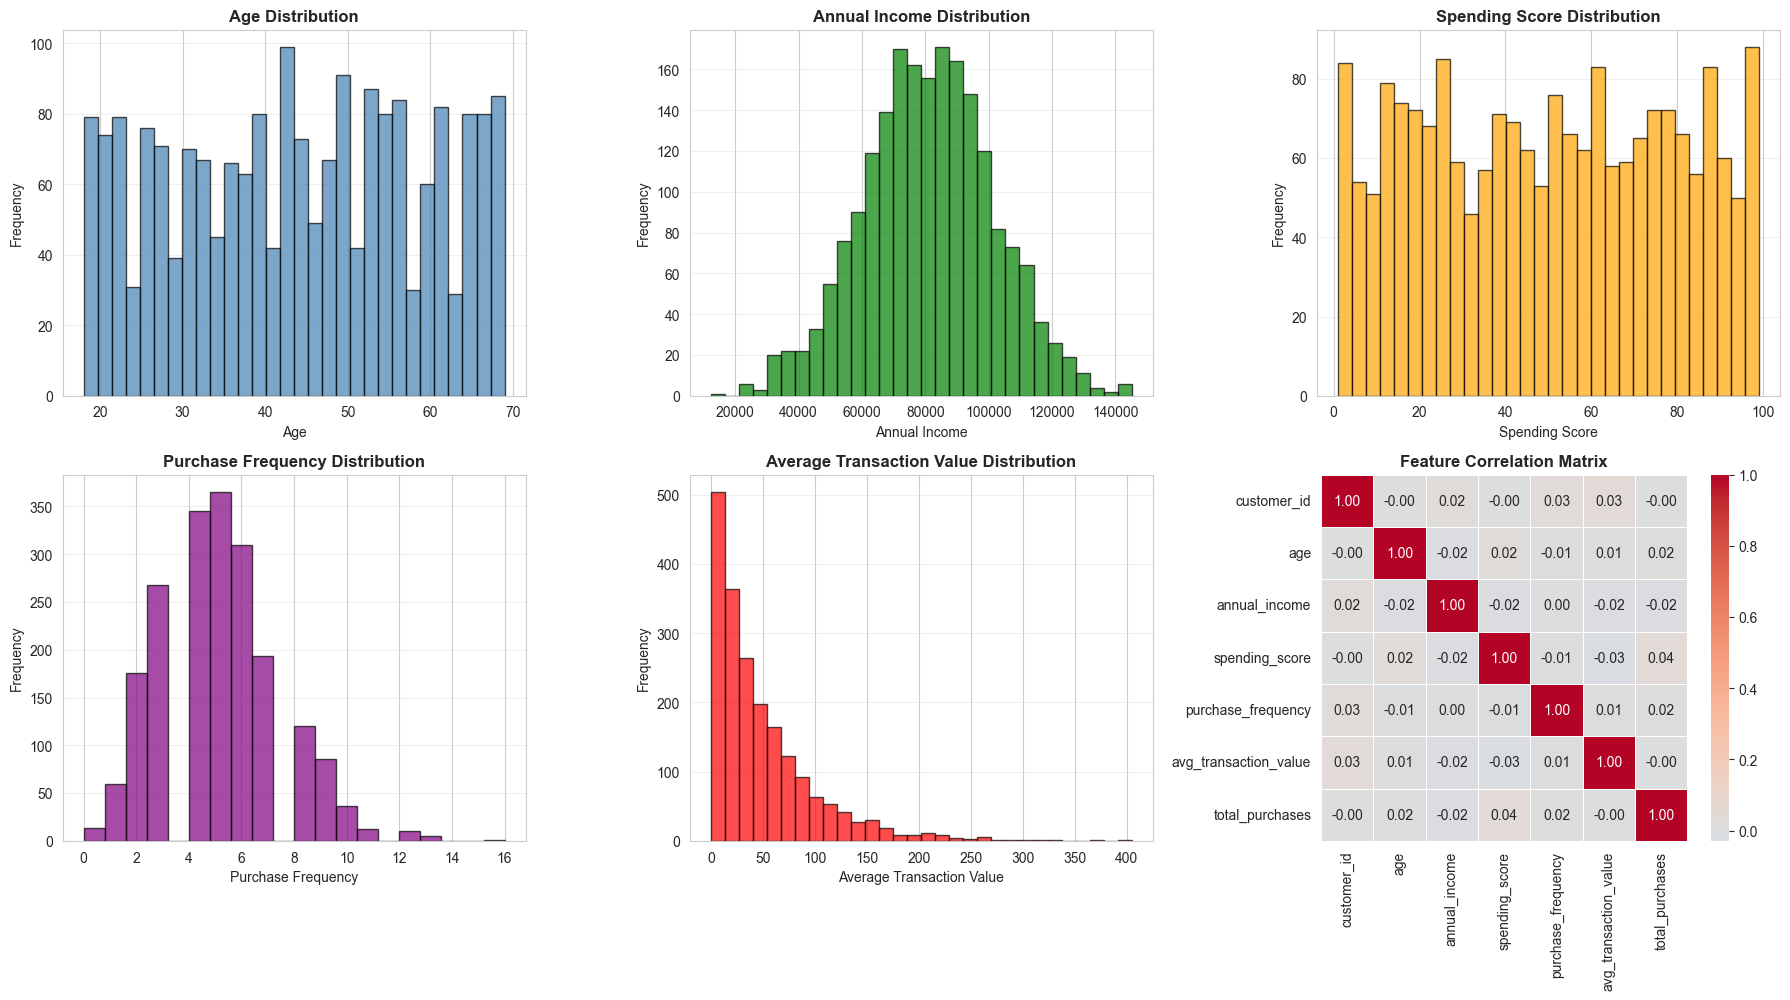

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age distribution
axes[0, 0].hist(df['age'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Age Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Income distribution
axes[0, 1].hist(df['annual_income'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Annual Income Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Annual Income')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Spending score distribution
axes[0, 2].hist(df['spending_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_title('Spending Score Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Spending Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Purchase frequency
axes[1, 0].hist(df['purchase_frequency'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_title('Purchase Frequency Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Purchase Frequency')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Average transaction value
axes[1, 1].hist(df['avg_transaction_value'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('Average Transaction Value Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Transaction Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Correlation heatmap
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, ax=axes[1, 2], fmt='.2f')
axes[1, 2].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Data Preprocessing**

In [6]:
feature_cols = ['age', 'annual_income', 'spending_score', 
                'purchase_frequency', 'avg_transaction_value', 'total_purchases']
X = df[feature_cols].values

print(f"Data shape: {X.shape}")

Data shape: (2000, 6)


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean(axis=0).round(3)}")
print(f"Std: {X_scaled.std(axis=0).round(3)}")

Scaled data shape: (2000, 6)
Mean: [-0. -0.  0.  0.  0. -0.]
Std: [1. 1. 1. 1. 1. 1.]


**Dimensionality Reduction**
1. PCA

In [8]:
pca = PCA()
pca.fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

[0.17779859 0.34901924 0.51775672 0.68115827 0.84213624 1.        ]
Components needed for 95% variance: 6


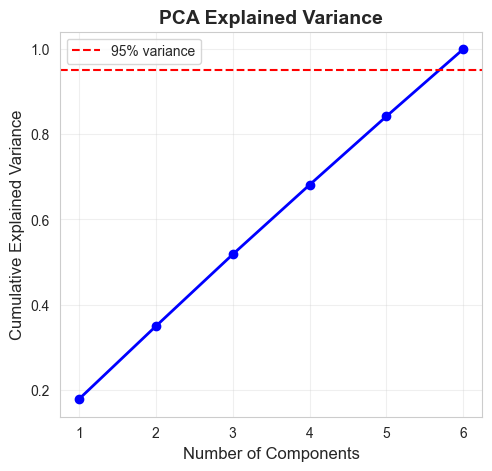

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA Explained Variance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

In [23]:
pca_3d = PCA(n_components=2, random_state=42)
x_pca = pca_3d.fit_transform(X_scaled)

print(f"Explained variance: {pca_3d.explained_variance_ratio_.sum():.3f}")

Explained variance: 0.349


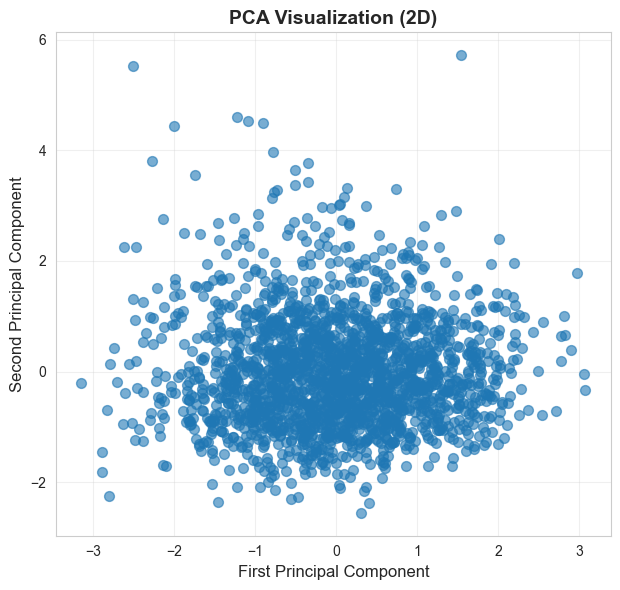

In [24]:
plt.subplot(1, 2, 2)
plt.scatter(x_pca[:, 0], x_pca[:, 1], alpha=0.6, s=50)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('PCA Visualization (2D)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

2. t-SNE

In [16]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
x_tsne = tsne.fit_transform(X_scaled)

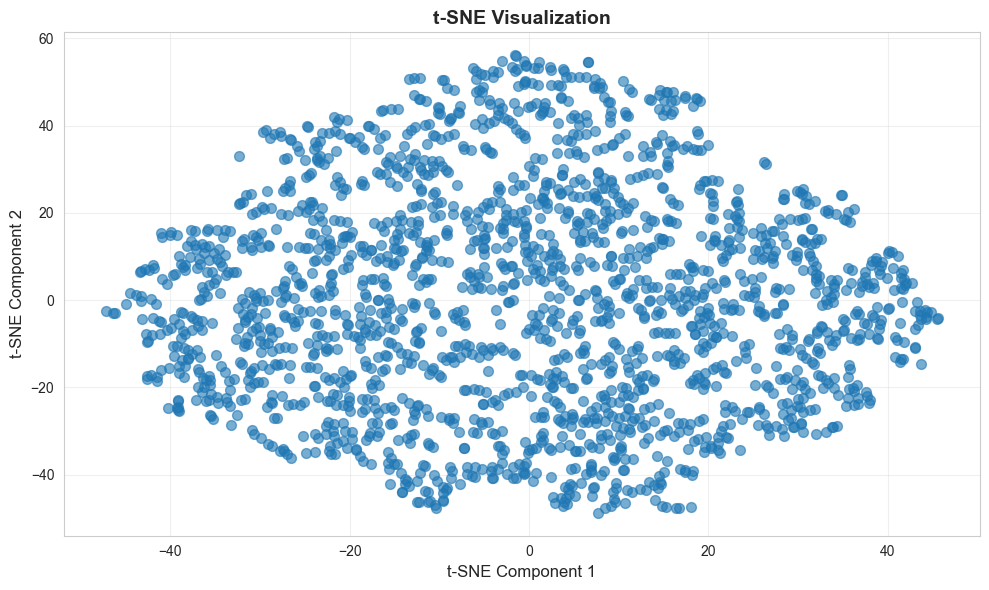

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], alpha=0.6, s=50)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Visualization', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

3. KPCA

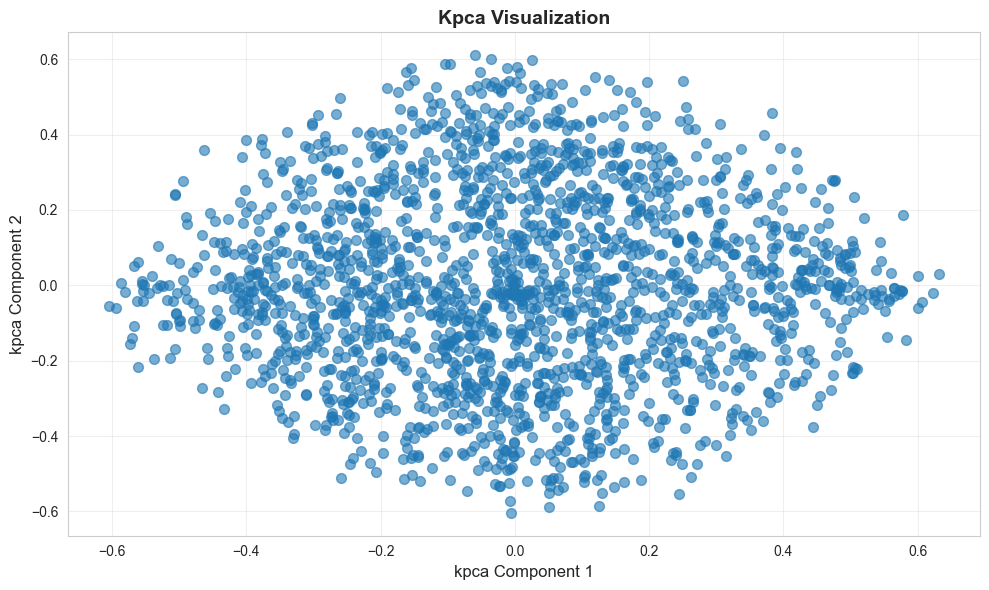

In [18]:
kpca = KernelPCA(n_components=2, kernel='rbf', random_state=42)
x_kpca = kpca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(x_kpca[:, 0], x_kpca[:, 1], alpha=0.6, s=50)
plt.xlabel('kpca Component 1', fontsize=12)
plt.ylabel('kpca Component 2', fontsize=12)
plt.title('Kpca Visualization', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Clustering Analysis**

- Kmeans

In [25]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(x_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x_pca, kmeans.labels_))
    

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k (Silhouette): {optimal_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.3f}")

Optimal k (Silhouette): 3
Best Silhouette Score: 0.353


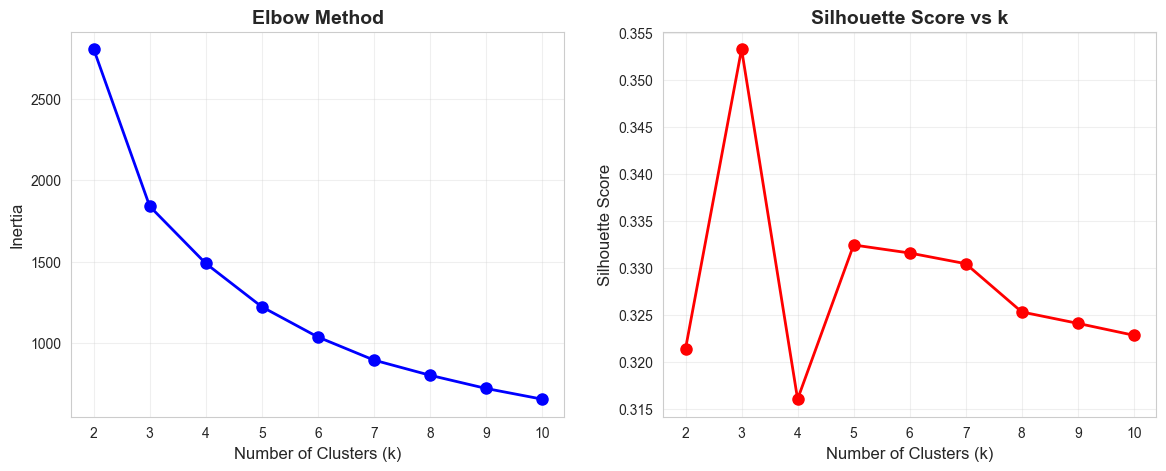

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

In [27]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(x_pca)

df['cluster_kmeans'] = clusters_kmeans

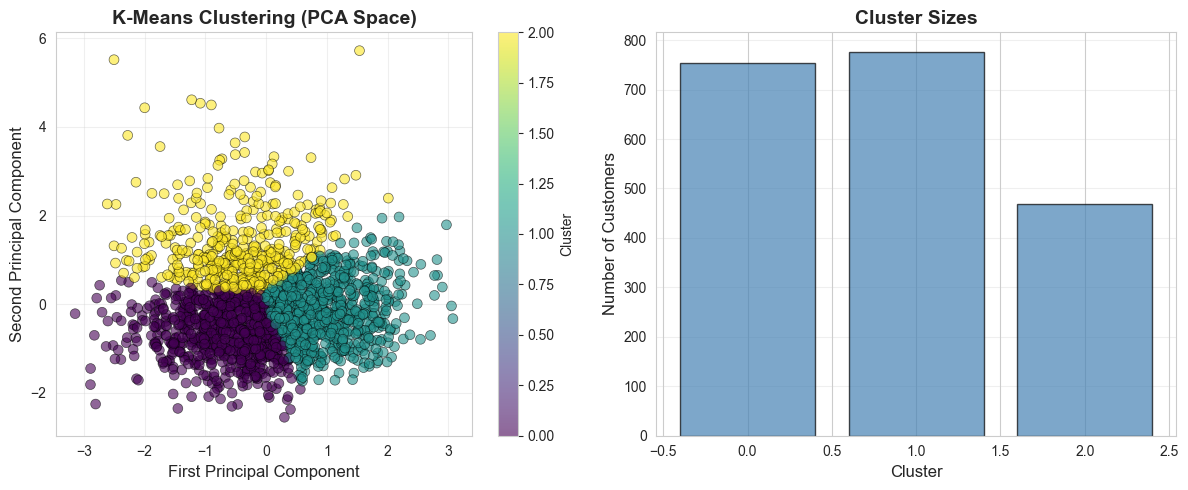

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidths=0.5)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('K-Means Clustering (PCA Space)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# Cluster sizes
plt.subplot(1, 2, 2)
unique, counts = np.unique(clusters_kmeans, return_counts=True)
plt.bar(unique, counts, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Cluster Sizes', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

- DBSCAN

In [29]:
# Find optimal eps
neighbors = NearestNeighbors(n_neighbors=4)
neighbors.fit(x_pca)
distances, indices = neighbors.kneighbors(x_pca)
distances = np.sort(distances[:, 3], axis=0)
optimal_eps = np.percentile(distances, 90)

In [30]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
clusters_dbscan = dbscan.fit_predict(x_pca)

n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = (clusters_dbscan == -1).sum()

print(f"\nDBSCAN Results:")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")


DBSCAN Results:
Number of clusters: 14
Number of noise points: 191


- Hierarchical Clustering

In [31]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
clusters_hierarchical = hierarchical.fit_predict(X_scaled)

print(f"\nHierarchical Clustering Results:")
print(f"Number of clusters: {optimal_k}")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters_hierarchical):.3f}")


Hierarchical Clustering Results:
Number of clusters: 3
Silhouette Score: 0.089


- Compare methods

In [32]:
comparison = pd.DataFrame({
    'Method': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Silhouette': [
        silhouette_score(x_pca, clusters_kmeans),
        silhouette_score(x_pca[clusters_dbscan != -1], clusters_dbscan[clusters_dbscan != -1]) if n_noise < len(X_scaled) else 0,
        silhouette_score(x_pca, clusters_hierarchical)
    ],
    'N_Clusters': [optimal_k, n_clusters_dbscan, optimal_k]
})

print("\nClustering Method Comparison:")
print(comparison)


Clustering Method Comparison:
         Method  Silhouette  N_Clusters
0       K-Means    0.353274           3
1        DBSCAN   -0.011462          14
2  Hierarchical    0.111681           3


#### Cluster Evaluation

- Analyze Cluster Characteristics

In [35]:
cluster_analysis = df.groupby('cluster_kmeans')[feature_cols].agg(['mean', 'std'])
cluster_analysis

age            annual_income                \
                     mean        std          mean           std   
cluster_kmeans                                                     
0               36.941645  13.688114  92231.637937  18357.445810   
1               49.975547  13.700334  74310.874266  18719.268229   
2               44.618337  14.126011  73626.653477  19115.662475   

               spending_score            purchase_frequency            \
                         mean        std               mean       std   
cluster_kmeans                                                          
0                   42.758621  25.994076           4.574271  2.024531   
1                   68.181467  23.000936           4.934363  2.226149   
2                   31.620469  23.636060           5.918977  2.365583   

               avg_transaction_value            total_purchases            
                                mean        std            mean       std  
cluster_kmeans                                                             
0                          28.737212  25.535119       18.095491  3.850652  
1                          36.130777  31.267483       22.195624  4.387227  
2                         102.318531  64.454425       19.637527  4.148004

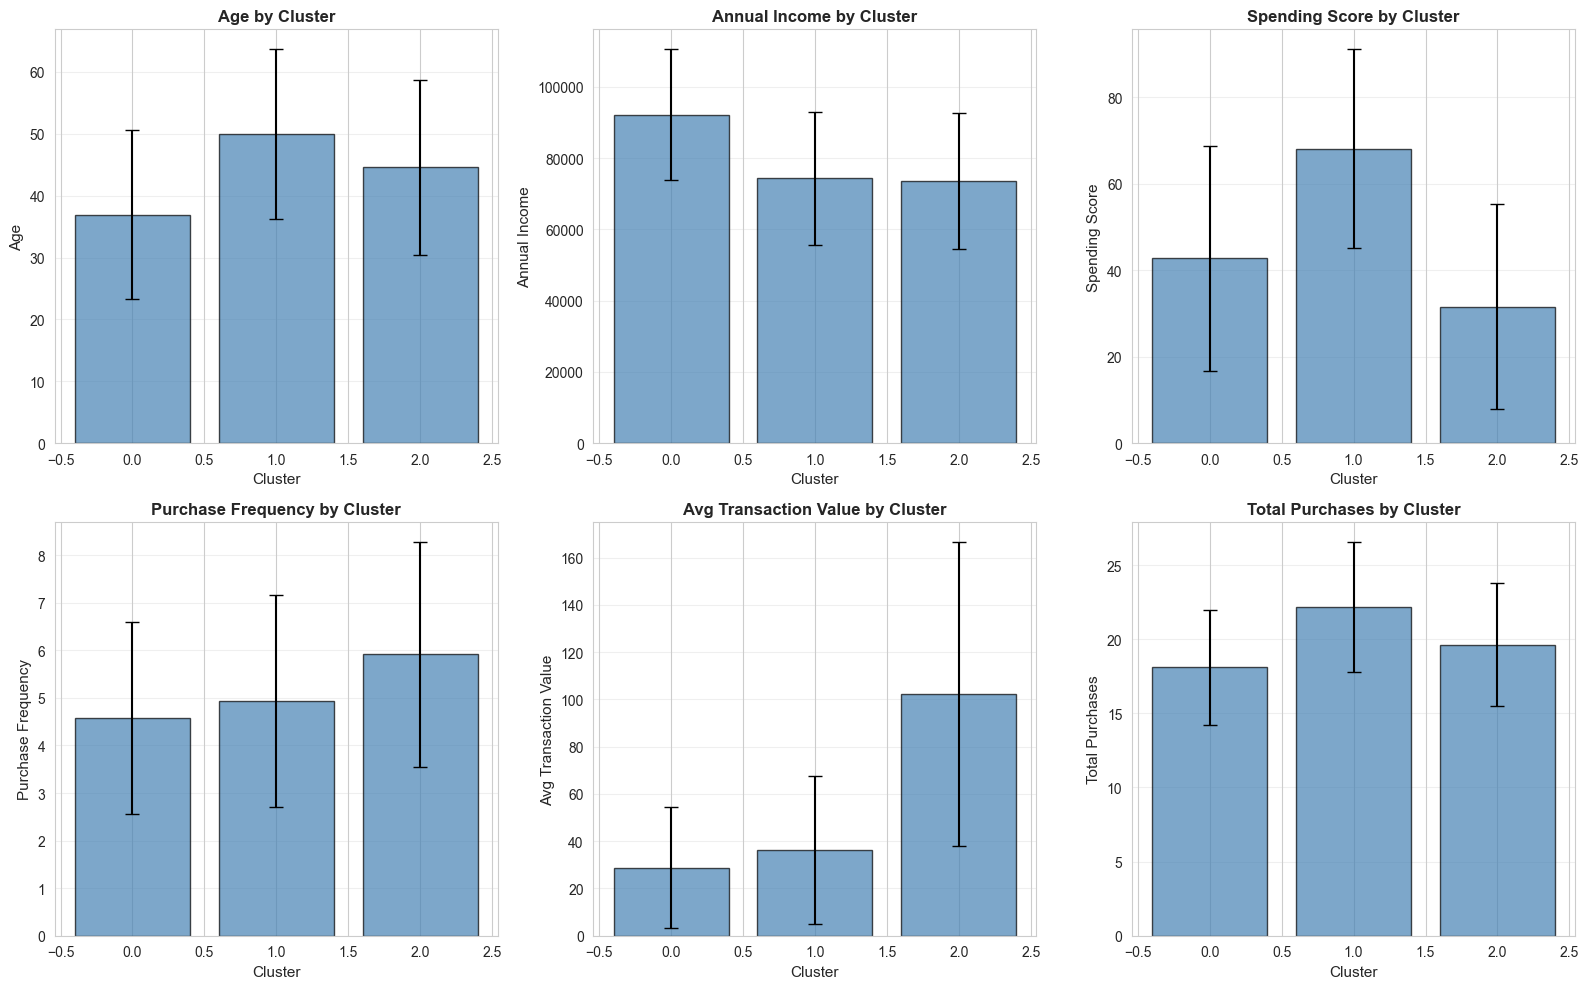

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, feature in enumerate(feature_cols):
    row = idx // 3
    col = idx % 3
    
    cluster_means = df.groupby('cluster_kmeans')[feature].mean()
    cluster_stds = df.groupby('cluster_kmeans')[feature].std()
    
    axes[row, col].bar(cluster_means.index, cluster_means.values, yerr=cluster_stds.values, alpha=0.7, color='steelblue', edgecolor='black', capsize=5)
    axes[row, col].set_xlabel('Cluster', fontsize=11)
    axes[row, col].set_ylabel(feature.replace('_', ' ').title(), fontsize=11)
    axes[row, col].set_title(f'{feature.replace("_", " ").title()} by Cluster',fontsize=12, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

- Comprehensive Evaluation

In [38]:
def evaluate_clustering(x, labels, name):
    if len(set(labels)) < 2:
        return None
    
    # Remove noise points for DBSCAN
    if -1 in labels:
        mask = labels != -1
        x_eval = x[mask]
        labels_eval = labels[mask]
    else:
        x_eval = x
        labels_eval = labels
        
    metrics = {
        'Method' : name,
        'N_Clusters': len(set(labels_eval)),
        'Silhouette': silhouette_score(x_eval, labels_eval),
        'Calinski-Harabasz': calinski_harabasz_score(x_eval, labels_eval),
        'Davies-Bouldin': davies_bouldin_score(x_eval, labels_eval)
    }
    return metrics

In [40]:
results = []
results.append(evaluate_clustering(x_pca, clusters_kmeans, 'K-Means'))
results.append(evaluate_clustering(x_pca, clusters_dbscan, 'DBSCAN'))
results.append(evaluate_clustering(x_pca, clusters_hierarchical, 'Hierarchical'))

results_df = pd.DataFrame([r for r in results if r is not None])
print("\nComprehensive Clustering Evaluation:")
print(results_df.round(3))


Comprehensive Clustering Evaluation:
         Method  N_Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin
0       K-Means           3       0.353           1275.383           0.901
1        DBSCAN          14      -0.011             23.980           0.581
2  Hierarchical           3       0.112            301.777           1.842


#### Anomaly Detection
- Isolation Forest

In [47]:
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
outliers_iso = iso_forest.fit_predict(X_scaled)

n_outliers_iso = (outliers_iso == -1).sum()
print(f"Isolation Forest detected {n_outliers_iso} outliers ({n_outliers_iso/len(X_scaled)*100:.1f}%)")

# Anomaly scores
anomaly_scores_iso = iso_forest.score_samples(X_scaled)
print(anomaly_scores_iso)

Isolation Forest detected 200 outliers (10.0%)
[-0.47134199 -0.5217729  -0.48632689 ... -0.5345012  -0.45208859
 -0.50319733]


- Local Outlier Factor

In [48]:
lof = LocalOutlierFactor(contamination=0.1, n_neighbors=20)
outliers_lof = lof.fit_predict(X_scaled)

n_outliers_lof = (outliers_lof == -1).sum()
print(f"LOF detected {n_outliers_lof} outliers ({n_outliers_lof/len(X_scaled)*100:.1f}%)")

anomaly_scores_lof = -lof.negative_outlier_factor_
print(anomaly_scores_lof)

LOF detected 200 outliers (10.0%)
[1.05665854 1.0855119  1.05109586 ... 1.24252675 0.98905207 1.13111466]


In [49]:
overlap = ((outliers_iso == -1) & (outliers_lof == -1)).sum()
print(f"\nOverlap between methods: {overlap} outliers detected by both")


Overlap between methods: 147 outliers detected by both


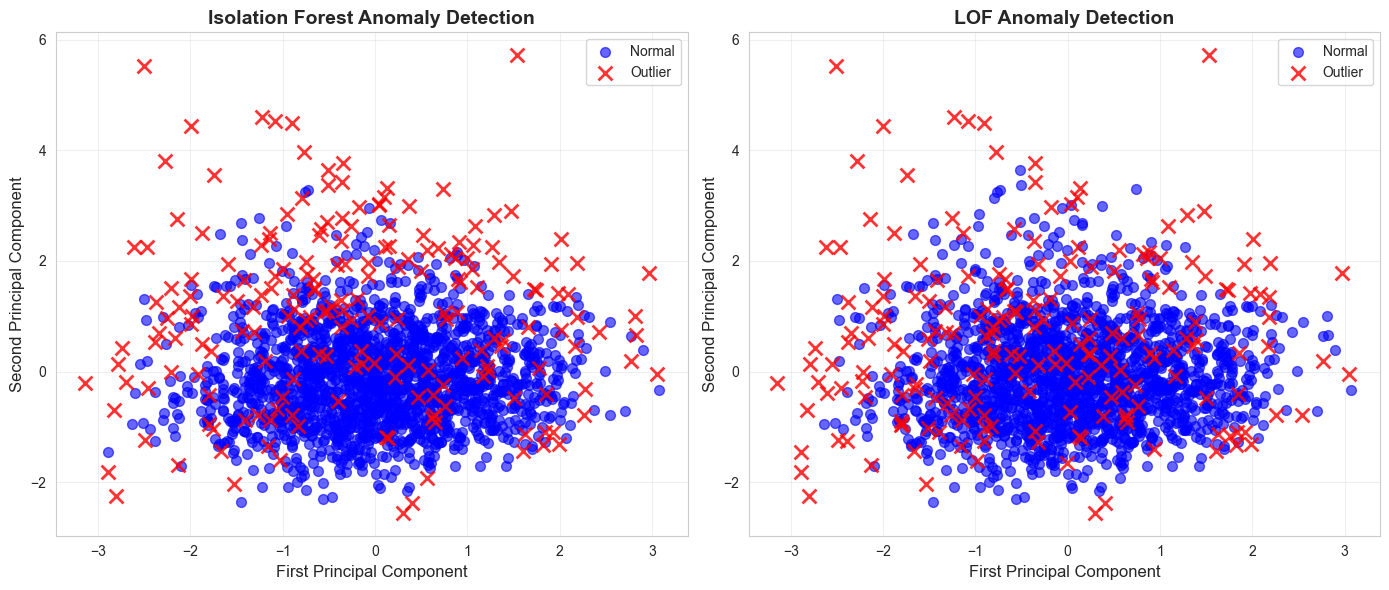

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Isolation Forest
normal_mask_iso = outliers_iso == 1
outlier_mask_iso = outliers_iso == -1

axes[0].scatter(x_pca[normal_mask_iso, 0], x_pca[normal_mask_iso, 1], c='blue', alpha=0.6, s=50, label='Normal')
axes[0].scatter(x_pca[outlier_mask_iso, 0], x_pca[outlier_mask_iso, 1], c='red', alpha=0.8, s=100, marker='x', linewidths=2, label='Outlier')
axes[0].set_xlabel('First Principal Component', fontsize=12)
axes[0].set_ylabel('Second Principal Component', fontsize=12)
axes[0].set_title('Isolation Forest Anomaly Detection', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LOF
normal_mask_lof = outliers_lof == 1
outlier_mask_lof = outliers_lof == -1

axes[1].scatter(x_pca[normal_mask_lof, 0], x_pca[normal_mask_lof, 1], c='blue', alpha=0.6, s=50, label='Normal')
axes[1].scatter(x_pca[outlier_mask_lof, 0], x_pca[outlier_mask_lof, 1], c='red', alpha=0.8, s=100, marker='x', linewidths=2, label='Outlier')
axes[1].set_xlabel('First Principal Component', fontsize=12)
axes[1].set_ylabel('Second Principal Component', fontsize=12)
axes[1].set_title('LOF Anomaly Detection', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Results Interpretation
- Customer Segments

In [51]:
print("=" * 60)
print("CUSTOMER SEGMENT PROFILES")
print("=" * 60)

for cluster_id in sorted(df['cluster_kmeans'].unique()):
    cluster_data = df[df['cluster_kmeans'] == cluster_id]
    
    print(f"\nCluster {cluster_id} ({len(cluster_data)} customers):")
    print(f"  Average Age: {cluster_data['age'].mean():.1f} years")
    print(f"  Average Annual Income: ${cluster_data['annual_income'].mean():.0f}")
    print(f"  Average Spending Score: {cluster_data['spending_score'].mean():.1f}")
    print(f"  Average Purchase Frequency: {cluster_data['purchase_frequency'].mean():.1f}")
    print(f"  Average Transaction Value: ${cluster_data['avg_transaction_value'].mean():.2f}")
    print(f"  Total Purchases: {cluster_data['total_purchases'].mean():.1f}")

CUSTOMER SEGMENT PROFILES

Cluster 0 (754 customers):
  Average Age: 36.9 years
  Average Annual Income: $92232
  Average Spending Score: 42.8
  Average Purchase Frequency: 4.6
  Average Transaction Value: $28.74
  Total Purchases: 18.1

Cluster 1 (777 customers):
  Average Age: 50.0 years
  Average Annual Income: $74311
  Average Spending Score: 68.2
  Average Purchase Frequency: 4.9
  Average Transaction Value: $36.13
  Total Purchases: 22.2

Cluster 2 (469 customers):
  Average Age: 44.6 years
  Average Annual Income: $73627
  Average Spending Score: 31.6
  Average Purchase Frequency: 5.9
  Average Transaction Value: $102.32
  Total Purchases: 19.6


- Actionable Insights

In [ ]:
# Generate insights
print("\n" + "=" * 60)
print("ACTIONABLE INSIGHTS")
print("=" * 60)

# Find high-value customers
high_value_cluster = df.groupby('cluster_kmeans')['annual_income'].mean().idxmax()
print(f"\n1. High-Value Customers (Cluster {high_value_cluster}):")
print(f"   - Target with premium products")
print(f"   - Offer loyalty programs")
print(f"   - Provide personalized service")

# Find high-spending customers
high_spending_cluster = df.groupby('cluster_kmeans')['spending_score'].mean().idxmax()
print(f"\n2. High-Spending Customers (Cluster {high_spending_cluster}):")
print(f"   - Focus on upselling")
print(f"   - Recommend complementary products")
print(f"   - Send frequent promotions")

# Anomaly insights
print(f"\n3. Anomalous Customers ({n_outliers_iso} detected):")
print(f"   - Review for fraud prevention")
print(f"   - Investigate unusual patterns")
print(f"   - Consider special handling")


ACTIONABLE INSIGHTS

1. High-Value Customers (Cluster 0):
   - Target with premium products
   - Offer loyalty programs
   - Provide personalized service

2. High-Spending Customers (Cluster 1):
   - Focus on upselling
   - Recommend complementary products
   - Send frequent promotions

3. Anomalous Customers (200 detected):
   - Review for fraud prevention
   - Investigate unusual patterns
   - Consider special handling


- Final Summary

In [55]:
print("\n" + "=" * 60)
print("PROJECT SUMMARY")
print("=" * 60)

print(f"\n1. Data: {len(df)} customers, {len(feature_cols)} features")
print(f"2. Optimal Clusters: {optimal_k} segments identified")
print(f"3. Clustering Quality: Silhouette Score = {silhouette_score(x_pca, clusters_kmeans):.3f}")
print(f"4. Anomalies Detected: {n_outliers_iso} customers ({n_outliers_iso/len(df)*100:.1f}%)")
print(f"5. Dimensionality Reduction: {pca_3d.explained_variance_ratio_.sum():.3f} variance explained in 2D")

print("\nKey Deliverables:")
print("  - Customer segmentation with {optimal_k} distinct groups")
print("  - Anomaly detection for fraud prevention")
print("  - Visualizations for stakeholder presentation")
print("  - Actionable insights for marketing strategy")


PROJECT SUMMARY

1. Data: 2000 customers, 6 features
2. Optimal Clusters: 3 segments identified
3. Clustering Quality: Silhouette Score = 0.353
4. Anomalies Detected: 200 customers (10.0%)
5. Dimensionality Reduction: 0.349 variance explained in 2D

Key Deliverables:
  - Customer segmentation with {optimal_k} distinct groups
  - Anomaly detection for fraud prevention
  - Visualizations for stakeholder presentation
  - Actionable insights for marketing strategy
